<a href="https://colab.research.google.com/github/Ahmed-Hossam-Aldeen/Deep-Learning-Tasks/blob/main/A3_Music_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# Cairo University Faculty of Engineering
## Deep Learning 
## Assignment 3

---

Please write your full name here
- **Name** : "Ahmed Hossam Aldeen"

# A3 Music Generation with RNNs

You will build a Recurrent Neural Network (RNN) for music generation. You will train a model to learn the patterns in raw sheet music in [ABC notation](https://en.wikipedia.org/wiki/ABC_notation) and then use this model to generate new music. 

In [ ]:
# Import Tensorflow 2.0
%tensorflow_version 2.x
import tensorflow as tf 

# Download and import the MIT 6.S191 package
!pip install mitdeeplearning
import mitdeeplearning as mdl

# Import all remaining packages
import numpy as np
import os
import time
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm
!apt-get install abcmidi timidity > /dev/null 2>&1

# Check that we are using a GPU, if not switch runtimes
#   using Runtime > Change Runtime Type > GPU
assert len(tf.config.list_physical_devices('GPU')) > 0

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 15.4 MB/s 
  Created wheel for mitdeeplearning: filename=mitdeeplearning-0.2.0-py3-none-any.whl size=2115441 sha256=f8b41803218ef367ae3e41cf0378126f32aa9f184f5ce8a63097f800755a76e1
  Stored in directory: /root/.cache/pip/wheels/9a/b9/4f/99b7c8c5c75355550b83e1fcfc02956fb40c35eb01e2262877
Successfully built mitdeeplearning


## 2.2 Dataset

![Let's Dance!](http://33.media.tumblr.com/3d223954ad0a77f4e98a7b87136aa395/tumblr_nlct5lFVbF1qhu7oio1_500.gif)

The dataset contains thousands of Irish folk songs, represented in the ABC notation. Let's download the dataset and inspect it: 


In [ ]:
# Download the dataset
songs = mdl.lab1.load_training_data()

# Print one of the songs to inspect it in greater detail!
example_song = songs[0]
print("\nExample song: ")
print(example_song)

Found 817 songs in text

Example song: 
X:1
T:Alexander's
Z: id:dc-hornpipe-1
M:C|
L:1/8
K:D Major
(3ABc|dAFA DFAd|fdcd FAdf|gfge fefd|(3efe (3dcB A2 (3ABc|!
dAFA DFAd|fdcd FAdf|gfge fefd|(3efe dc d2:|!
AG|FAdA FAdA|GBdB GBdB|Acec Acec|dfaf gecA|!
FAdA FAdA|GBdB GBdB|Aceg fefd|(3efe dc d2:|!


Convert a song in ABC notation to an audio waveform and play it back. Be patient for this conversion to run, it can take some time.

In [ ]:
# Convert the ABC notation to audio file and listen to it
mdl.lab1.play_song(example_song)

One important thing to think about is that this notation of music does not simply contain information on the notes being played, but additionally there is meta information such as the song title, key, and tempo. How does the number of different characters that are present in the text file impact the complexity of the learning problem? This will become important soon, when we generate a numerical representation for the text data.

In [ ]:
# Join our list of song strings into a single string containing all songs
songs_joined = "\n\n".join(songs) 

# Find all unique characters in the joined string
vocab = sorted(set(songs_joined))
print("There are", len(vocab), "unique characters in the dataset")

There are 83 unique characters in the dataset


- **Question:** How many songs are in the dataset?
    - **Answer:** 817 

## 2.3 Process the dataset for the learning task

Let's take a step back and consider our prediction task. We're trying to train a RNN model to learn patterns in ABC music, and then use this model to generate (i.e., predict) a new piece of music based on this learned information. 

Breaking this down, what we're really asking the model is: given a character, or a sequence of characters, what is the most probable next character? We'll train the model to perform this task. 

To achieve this, we will input a sequence of characters to the model, and train the model to predict the output, that is, the following character at each time step. RNNs maintain an internal state that depends on previously seen elements, so information about all characters seen up until a given moment will be taken into account in generating the prediction.

### Vectorize the text

Before we begin training our RNN model, we'll need to create a numerical representation of our text-based dataset. To do this, we'll generate two lookup tables: one that maps characters to numbers, and a second that maps numbers back to characters. Recall that we just identified the unique characters present in the text.

In [ ]:
### Define numerical representation of text ###

# Create a mapping from character to unique index.
# For example, to get the index of the character "d", 
#   we can evaluate `char2idx["d"]`.  
char2idx = {u:i for i, u in enumerate(vocab)}

# Create a mapping from indices to characters. This is
#   the inverse of char2idx and allows us to convert back
#   from unique index to the character in our vocabulary.
idx2char = np.array(vocab)

This gives us an integer representation for each character. Observe that the unique characters (i.e., our vocabulary) in the text are mapped as indices from 0 to `len(unique)`. Let's take a peek at this numerical representation of our dataset:

In [ ]:
print('{')
for char,_ in zip(char2idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '"' :   3,
  '#' :   4,
  "'" :   5,
  '(' :   6,
  ')' :   7,
  ',' :   8,
  '-' :   9,
  '.' :  10,
  '/' :  11,
  '0' :  12,
  '1' :  13,
  '2' :  14,
  '3' :  15,
  '4' :  16,
  '5' :  17,
  '6' :  18,
  '7' :  19,
  ...
}


In [ ]:
### Vectorize the songs string ###

'''TODO: Write a function to convert the all songs string to a vectorized
    (i.e., numeric) representation. Use the appropriate mapping given
    above to convert from vocab characters to the corresponding indices.

  NOTE: the output of the `vectorize_string` function 
  should be a np.array with `N` elements, where `N` is
  the number of characters in the input string
'''

def vectorize_string(string):
    string_vectorized = []
    for i in string:
        string_vectorized.append(char2idx[i])

    string_vectorized = np.array(string_vectorized)    
    return string_vectorized
    

vectorized_songs = vectorize_string(songs_joined)

We can also look at how the first part of the text is mapped to an integer representation:

In [ ]:
print ('{} ---- characters mapped to int ----> {}'.format(repr(songs_joined[:10]), vectorized_songs[:10]))
# check that vectorized_songs is a numpy array
assert isinstance(vectorized_songs, np.ndarray), "returned result should be a numpy array"

'X:1\nT:Alex' ---- characters mapped to int ----> [49 22 13  0 45 22 26 67 60 79]


### Create training examples and targets

Our next step is to actually divide the text into example sequences that we'll use during training. Each input sequence that we feed into our RNN will contain `seq_length` characters from the text. We'll also need to define a target sequence for each input sequence, which will be used in training the RNN to predict the next character. For each input, the corresponding target will contain the same length of text, except shifted one character to the right.

To do this, we'll break the text into chunks of `seq_length+1`. Suppose `seq_length` is 4 and our text is "Hello". Then, our input sequence is "Hell" and the target sequence is "ello".

The batch method will then let us convert this stream of character indices to sequences of the desired size.

In [ ]:
### Batch definition to create training examples ###

def get_batch(vectorized_songs, seq_length, batch_size):
  # the length of the vectorized songs string
  n = vectorized_songs.shape[0] - 1                            ##200678
  # randomly choose the starting indices for the examples in the training batch
  idx = np.random.choice(n-seq_length, batch_size)

  print(n)
  print(idx)
  '''TODO: construct a list of input sequences for the training batch'''
  #input_batch = vectorized_songs[int(idx): int(idx)+seq_length]
  input_batch = [vectorized_songs[i : i+seq_length] for i in idx]
  '''TODO: construct a list of output sequences for the training batch'''
  #output_batch = vectorized_songs[int(idx)+1: int(idx)+seq_length+1]
  output_batch = [vectorized_songs[i+1 : i+seq_length+1] for i in idx]

  print(input_batch)

  # x_batch, y_batch provide the true inputs and targets for network training
  x_batch = np.reshape(input_batch, [batch_size, seq_length])
  y_batch = np.reshape(output_batch, [batch_size, seq_length])
  return x_batch, y_batch




For each of these vectors, each index is processed at a single time step. So, for the input at time step 0, the model receives the index for the first character in the sequence, and tries to predict the index of the next character. At the next timestep, it does the same thing, but the RNN considers the information from the previous step, i.e., its updated state, in addition to the current input.

We can make this concrete by taking a look at how this works over the first several characters in our text:

In [ ]:
x_batch, y_batch = get_batch(vectorized_songs, seq_length=5, batch_size=1)

for i, (input_idx, target_idx) in enumerate(zip(np.squeeze(x_batch), np.squeeze(y_batch))):
    print("Step {:3d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

200678
[41257]
[array([82,  2,  0,  0, 49])]
Step   0
  input: 82 ('|')
  expected output: 2 ('!')
Step   1
  input: 2 ('!')
  expected output: 0 ('\n')
Step   2
  input: 0 ('\n')
  expected output: 0 ('\n')
Step   3
  input: 0 ('\n')
  expected output: 49 ('X')
Step   4
  input: 49 ('X')
  expected output: 22 (':')


## 2.4 The Recurrent Neural Network (RNN) model

Now we're ready to define and train a RNN model on our ABC music dataset, and then use that trained model to generate a new song. We'll train our RNN using batches of song snippets from our dataset, which we generated in the previous section.

The model is based off the LSTM architecture, where we use a state vector to maintain information about the temporal relationships between consecutive characters. The final output of the LSTM is then fed into a fully connected [`Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layer where we'll output a softmax over each character in the vocabulary, and then sample from this distribution to predict the next character. 

As we introduced in the first portion of this lab, we'll be using the Keras API, specifically, [`tf.keras.Sequential`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential), to define the model. Three layers are used to define the model:

* [`tf.keras.layers.Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding): This is the input layer, consisting of a trainable lookup table that maps the numbers of each character to a vector with `embedding_dim` dimensions.
* [`tf.keras.layers.LSTM`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM): Our LSTM network, with size `units=rnn_units`. 
* [`tf.keras.layers.Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense): The output layer, with `vocab_size` outputs.


<img src="https://raw.githubusercontent.com/aamini/introtodeeplearning/2019/lab1/img/lstm_unrolled-01-01.png" alt="Drawing"/>

### Define the RNN model

Now, we will define a function that we will use to actually build the model.

In [ ]:
def LSTM(rnn_units): 
  return tf.keras.layers.LSTM(
    rnn_units, 
    return_sequences=True, 
    recurrent_initializer='glorot_uniform',
    recurrent_activation='sigmoid',
    stateful=True,
  )

The time has come! Fill in the `TODOs` to define the RNN model within the `build_model` function, and then call the function you just defined to instantiate the model!

In [ ]:
### Defining the RNN Model ###

'''TODO: Add LSTM and Dense layers to define the RNN model using the Sequential API.'''
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    # Layer 1: Embedding layer to transform indices into dense vectors 
    #   of a fixed embedding size
    tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),

    # Layer 2: LSTM with `rnn_units` number of units. 
    # TODO: Call the LSTM function defined above to add this layer.
    LSTM(rnn_units),

    # Layer 3: Dense (fully-connected) layer that transforms the LSTM output
    #   into the vocabulary size. 
    # TODO: Add the Dense layer.
    tf.keras.layers.Dense(vocab_size)
  ])

  return model

# Build a simple model with default hyperparameters. You will get the 
#   chance to change these later.
model = build_model(len(vocab), embedding_dim=256, rnn_units=1024, batch_size=32)

- Why do we need batch size? What's "stateful" argument?
  - Read up on stateful vs stateless LSTM
      - http://philipperemy.github.io/keras-stateful-lstm/
      - https://stackoverflow.com/questions/39681046/keras-stateful-vs-stateless-lstms

### Test out the RNN model

It's always a good idea to run a few simple checks on our model to see that it behaves as expected.  

First, we can use the `Model.summary` function to print out a summary of our model's internal workings. Here we can check the layers in the model, the shape of the output of each of the layers, the batch size, etc.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (32, None, 256)           21248     
                                                                 
 lstm (LSTM)                 (32, None, 1024)          5246976   
                                                                 
 dense (Dense)               (32, None, 83)            85075     
                                                                 
Total params: 5,353,299
Trainable params: 5,353,299
Non-trainable params: 0
_________________________________________________________________


We can also quickly check the dimensionality of our output, using a sequence length of 100. Note that the model can be run on inputs of any length.

In [ ]:
x, y = get_batch(vectorized_songs, seq_length=100, batch_size=32)
pred = model(x)
print("Input shape:      ", x.shape, " # (batch_size, sequence_length)")
print("Prediction shape: ", pred.shape, "# (batch_size, sequence_length, vocab_size)")

200678
[ 17355 120643  93708 134874 142258  78027  75877  63847  86665  35121
 163211  82925  47879  90034  60978  21241 194630  40555  61959  21234
  40968  45275  37009 134804  69865 124960 153625  26700  96561  22365
 101983   9318]
[array([26,  8, 31, 82, 26, 58, 27, 59,  1, 58, 60, 22, 82,  2,  0, 62, 61,
       82, 60, 14, 58, 60,  1, 62, 56, 62, 60, 82, 61, 14, 59, 61,  1, 56,
       57, 56, 62, 82, 60, 14, 58, 60,  1, 56, 62, 61, 60, 82, 59, 58, 27,
       26,  1, 32, 14, 62, 61, 82,  2,  0, 60, 14, 58, 60,  1, 62, 56, 62,
       60, 82, 61, 14, 59, 61,  1, 56, 57, 56, 62, 82, 60, 14, 58, 60,  1,
       59, 14, 27, 59, 82, 58, 14, 58, 27,  1, 58, 14, 22, 82,  2]), array([ 1, 41, 64, 58, 66, 64, 69, 62,  1, 28, 70, 58, 66, 67, 60, 74,  0,
       51, 22,  1, 64, 59, 22, 59, 58,  9, 73, 60, 60, 67,  9, 13, 16, 18,
        0, 38, 22, 28,  0, 37, 22, 13, 11, 20,  0, 36, 22, 29,  1, 38, 64,
       79, 70, 67, 80, 59, 64, 56, 69,  0, 26, 59, 59, 58,  1, 26, 32, 30,
       31, 82, 32, 

### Predictions from the untrained model

Let's take a look at what our untrained model is predicting.

To get actual predictions from the model, we sample from the output distribution, which is defined by a `softmax` over our character vocabulary. This will give us actual character indices. This means we are using a [categorical distribution](https://en.wikipedia.org/wiki/Categorical_distribution) to sample over the example prediction. This gives a prediction of the next character (specifically its index) at each timestep.

Note here that we sample from this probability distribution, as opposed to simply taking the `argmax`, which can cause the model to get stuck in a loop.

Let's try this sampling out for the first example in the batch.

In [ ]:
sampled_indices = tf.random.categorical(pred[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()
sampled_indices

array([46,  6, 52, 77, 33, 34,  1, 35, 24, 18, 24, 66, 14, 45, 22, 24, 17,
        1,  1, 15,  9, 49, 80, 16, 12, 74, 71,  3, 33, 58,  3, 77, 11, 19,
       48, 27, 50, 15, 42, 60, 17, 38, 45, 25,  1, 78,  2,  7,  4, 24, 68,
       21, 70, 26, 12,  9, 78, 80, 55, 10, 30, 71, 22, 52, 56, 66, 23,  3,
       42, 13, 40,  0, 23, 77, 37, 69, 57, 25, 28, 55, 74, 25, 32, 37, 18,
       70,  9, 50, 42, 35, 11, 11, 33, 27, 32, 53, 69, 75, 65, 77])

We can now decode these to see the text predicted by the untrained model:

In [ ]:
print("Input: \n", repr("".join(idx2char[x[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices])))

Input: 
 'A,F|AcBd ce:|!\ngf|e2ce gage|f2df abag|e2ce agfe|dcBA G2gf|!\ne2ce gage|f2df abag|e2ce d2Bd|c2cB c2:|!'

Next Char Predictions: 
 'U([vHI J=6=k2T:=5  3-Xy40sp"Hc"v/7WBY3Qe5MT> w!)#=m9oA0-wy_.Ep:[ak<"Q1O\n<vLnb>C_s>GL6o-YQJ//HBG]ntjv'


As you can see, the text predicted by the untrained model is pretty nonsensical! How can we do better? We can train the network!

## 2.5 Training the model: loss and training operations

Now it's time to train the model!

At this point, we can think of our next character prediction problem as a standard classification problem. Given the previous state of the RNN, as well as the input at a given time step, we want to predict the class of the next character -- that is, to actually predict the next character. 

To train our model on this classification task, we can use a form of the `crossentropy` loss (negative log likelihood loss). Specifically, we will use the [`sparse_categorical_crossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/sparse_categorical_crossentropy) loss, as it utilizes integer targets for categorical classification tasks. We will want to compute the loss using the true targets -- the `labels` -- and the predicted targets -- the `logits`.

Let's first compute the loss using our example predictions from the untrained model: 

In [ ]:
### Defining the loss function ###

'''TODO: define the loss function to compute and return the loss between
    the true labels and predictions (logits). Set the argument from_logits=True.'''
def compute_loss(labels, logits):
  loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True) # TODO
  return loss

'''TODO: compute the loss using the true next characters from the example batch 
    and the predictions from the untrained model several cells above'''
example_batch_loss = compute_loss(y, pred) # TODO

print("Prediction shape: ", pred.shape, " # (batch_size, sequence_length, vocab_size)") 
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (32, 100, 83)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.4178953


Let's start by defining some hyperparameters for training the model. To start, we have provided some reasonable values for some of the parameters.

In [ ]:
### Hyperparameter setting and optimization ###

# Optimization parameters:
num_training_iterations = 2000  # Increase this to train longer
batch_size = 4  # Experiment between 1 and 64
seq_length = 100  # Experiment between 50 and 500
learning_rate = 5e-3  # Experiment between 1e-5 and 1e-1

# Model parameters: 
vocab_size = len(vocab)
embedding_dim = 256 
rnn_units = 1024  # Experiment between 1 and 2048

# Checkpoint location: 
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

Now, we are ready to define our training operation -- the optimizer and duration of training -- and use this function to train the model. You will experiment with the choice of optimizer and the duration for which you train your models, and see how these changes affect the network's output. Some optimizers you may like to try are [`Adam`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam?version=stable) and [`Adagrad`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adagrad?version=stable).

First, we will instantiate a new model and an optimizer. Then, we will use the [`tf.GradientTape`](https://www.tensorflow.org/api_docs/python/tf/GradientTape) method to perform the backpropagation operations. 

We will also generate a print-out of the model's progress through training, which will help us easily visualize whether or not we are minimizing the loss.

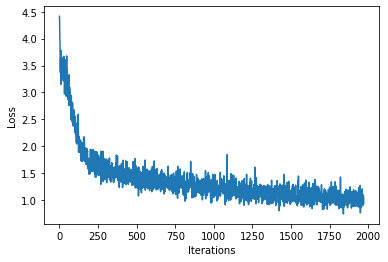

 99%|█████████▉| 1978/2000 [00:59<00:00, 30.25it/s]

200678
[  5214 131478  80896  92832]
[array([61, 59,  1, 60, 59,  1,  6, 15, 27, 58, 59, 82, 60, 59, 54, 58, 60,
        1, 59, 14,  1, 60, 61, 82,  2,  0, 62, 60, 59, 58,  1, 27, 32, 27,
       59, 82, 60, 58, 26, 32,  1, 31, 26, 29, 31, 82, 32, 27, 59, 27,  1,
       58, 26, 31, 32, 82,  6, 15, 26, 27, 26,  1, 32, 31,  1, 32, 14, 22,
       82,  2,  0,  0, 49, 22, 14, 12,  0, 45, 22, 30, 58, 63, 70,  0, 51,
       22,  1, 64, 59, 22, 59, 58,  9, 63, 70, 73, 69, 71, 64, 71]), array([61,  1, 56, 61, 59, 61, 82, 56, 61, 59, 61,  1, 56, 14, 62, 61, 82,
       60, 61, 62, 56,  1, 57, 62, 60, 58, 82, 59, 58, 27, 26,  1, 31, 26,
       27, 58, 82,  2,  0, 59, 61, 61, 14,  1, 60, 58, 59, 27, 82, 26, 31,
       29, 31,  1, 26, 14, 27, 58, 82, 58, 27, 27, 26,  1, 27, 31, 26, 31,
       82, 30, 31, 32, 26,  1, 27, 58, 22, 82,  2,  0, 59, 60, 82, 61, 56,
       56, 14,  1, 61, 59, 56, 59, 82, 61, 56, 56, 14,  1, 61, 59]), array([80,  5, 74,  0, 51, 22,  1, 64, 59, 22, 59, 58,  9, 71, 70, 67, 66,

 99%|█████████▉| 1987/2000 [00:59<00:00, 34.44it/s]

200678
[ 81668 101689 172088   2407]
[array([11, 32, 11, 82, 26, 32,  1, 32, 22, 82,  2,  0, 27, 11, 58, 11, 82,
       59, 27,  1, 32, 25, 26, 82, 27, 32,  1, 30, 29, 82, 59, 27,  1, 32,
       25, 26, 82, 27, 26,  1, 26, 27, 11, 58, 11, 82,  2,  0, 59, 27,  1,
       32, 25, 26, 82, 27, 32,  1, 30, 29, 82, 27, 32,  1, 29, 11, 30, 11,
        1, 31, 11, 32, 11, 82, 26, 32,  1, 32, 22, 82,  2,  0,  0, 49, 22,
       16, 18,  0, 45, 22, 46, 71,  1, 56, 69, 59,  1, 26, 78, 56]), array([60, 59, 60, 61,  1, 62, 61, 62, 60, 82, 59, 58, 59, 27,  1, 32, 26,
       27, 32, 82, 53,  2,  0,  0, 49, 22, 20, 13,  0, 45, 22, 29, 76, 57,
       67, 64, 69,  0, 51, 22,  1, 64, 59, 22, 59, 58,  9, 73, 60, 60, 67,
        9, 19, 16,  0, 38, 22, 28,  0, 37, 22, 13, 11, 20,  0, 36, 22, 32,
        1, 38, 56, 65, 70, 73,  0, 60, 61, 82, 62, 27, 27, 14,  1, 62, 27,
       56, 27, 82, 62, 27, 27, 14,  1, 59, 27, 26, 27, 82, 62, 27]), array([ 1, 60, 26, 58, 26, 82, 27, 14, 54, 59, 27,  1, 61, 27, 59, 27, 82,

100%|█████████▉| 1996/2000 [01:00<00:00, 36.71it/s]

200678
[ 79778  60249 196647 124531]
[array([66, 56,  9, 14, 21,  0, 38, 22, 14, 11, 16,  0, 37, 22, 13, 11, 20,
        0, 36, 22, 29,  1, 38, 56, 65, 70, 73,  0, 61, 59,  1, 26, 59, 82,
       61, 59,  1, 26, 59, 82, 61, 59, 11, 27, 11,  1, 26, 31, 82, 30, 14,
        1, 30, 14, 82,  2,  0, 61, 59,  1, 26, 59, 82, 61, 59,  1, 26, 59,
       82, 61, 59, 11, 27, 11,  1, 26, 31, 82, 29, 14,  1, 29, 14, 22, 82,
        2,  0, 31, 29,  1, 31, 26, 82, 59, 60,  1, 61, 11, 62, 11]), array([57, 82, 56, 62, 60,  1, 59, 27, 26, 82,  2,  0, 27, 14, 32,  1, 26,
       32, 30, 82, 32, 30, 29,  1, 32, 27, 59, 82, 60, 59, 27,  1, 59, 27,
       26, 82, 27, 32, 31,  1, 32, 14, 22, 82,  2,  0, 59, 82, 62, 61, 62,
        1, 60, 59, 27, 82, 59, 62, 57,  1, 56, 62, 60, 82, 62, 61, 62,  1,
       60, 59, 27, 82, 32, 27, 59,  1, 60, 14, 61, 82,  2,  0, 62, 61, 62,
        1, 60, 59, 27, 82, 59, 62, 57,  1, 56, 62, 60, 82, 59, 54]), array([59, 22, 59, 58,  9, 74, 67, 64, 71, 65, 64, 62,  9, 13, 19,  0, 38,

100%|██████████| 2000/2000 [01:00<00:00, 33.20it/s]


200678
[ 79544 115698  10459 168082]
[array([67,  1, 31, 60, 60, 74,  5,  0, 51, 22,  1, 64, 59, 22, 59, 58,  9,
       71, 70, 67, 66, 56,  9, 14, 20,  0, 38, 22, 14, 11, 16,  0, 37, 22,
       13, 11, 20,  0, 36, 22, 29,  1, 38, 56, 65, 70, 73,  0, 29, 15, 27,
       82, 26, 31, 14, 27, 82, 26, 31,  1, 29, 25, 30, 82, 31, 30,  1, 30,
       14, 82,  2,  0, 29, 15, 27, 82, 26, 31, 14, 27, 82, 26, 31,  1, 30,
       31, 82, 29, 14,  1, 29, 14, 22, 82,  2,  0, 59, 14,  1, 58]), array([64, 58, 60, 69, 75,  1, 44, 60, 77, 60, 69,  0, 51, 22,  1, 64, 59,
       22, 59, 58,  9, 73, 60, 60, 67,  9, 13, 14, 19,  0, 38, 22, 16, 11,
       16,  0, 37, 22, 13, 11, 20,  0, 36, 22, 26,  1, 29, 70, 73, 64, 56,
       69,  0, 30, 26, 26, 32,  1, 26, 27, 58, 26, 82, 30, 26, 31, 26,  1,
       32, 30, 29, 32, 82, 30, 26, 26, 32,  1, 26, 27, 58, 59, 82, 60, 62,
       59, 27,  1, 58, 26, 26, 14, 22, 82,  2,  0, 26, 27, 58, 59]), array([26, 14, 62, 14, 82, 61, 62, 56, 61,  1, 57, 62, 60, 58, 82, 59, 14,

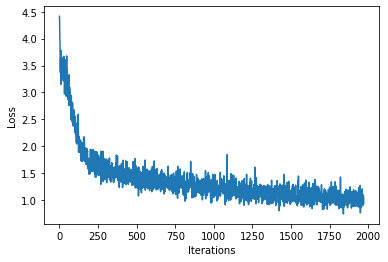

In [ ]:
### Define optimizer and training operation ###

'''TODO: instantiate a new model for training using the `build_model`
  function and the hyperparameters created above.'''
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size)

'''TODO: instantiate an optimizer with its learning rate.
  Checkout the tensorflow website for a list of supported optimizers.
  https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/
  Try using the Adam optimizer to start.'''
optimizer = tf.keras.optimizers.Adam()
@tf.function
def train_step(x, y): 
  # Use tf.GradientTape()
  with tf.GradientTape() as tape:
  
    '''TODO: feed the current input into the model and generate predictions'''
    y_hat = model(x)
  
    '''TODO: compute the loss!'''
    loss = compute_loss(y, y_hat)

  # Now, compute the gradients 
  '''TODO: complete the function call for gradient computation. 
      Remember that we want the gradient of the loss with respect all 
      of the model parameters. 
      HINT: use `model.trainable_variables` to get a list of all model
      parameters.'''
  grads = tape.gradient(loss, model.trainable_variables)
  
  # Apply the gradients to the optimizer so it can update the model accordingly
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss

##################
# Begin training!#
##################

history = []
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for iter in tqdm(range(num_training_iterations)):

  # Grab a batch and propagate it through the network
  x_batch, y_batch = get_batch(vectorized_songs, seq_length, batch_size)
  loss = train_step(x_batch, y_batch)

  # Update the progress bar
  history.append(loss.numpy().mean())
  plotter.plot(history)

  # Update the model with the changed weights!
  if iter % 100 == 0:     
    model.save_weights(checkpoint_prefix)
    
# Save the trained model and the weights
model.save_weights(checkpoint_prefix)


## 2.6 Generate music using the RNN model

Now, we can use our trained RNN model to generate some music! When generating music, we'll have to feed the model some sort of seed to get it started (because it can't predict anything without something to start with!).

Once we have a generated seed, we can then iteratively predict each successive character (remember, we are using the ABC representation for our music) using our trained RNN. More specifically, recall that our RNN outputs a `softmax` over possible successive characters. For inference, we iteratively sample from these distributions, and then use our samples to encode a generated song in the ABC format.

Then, all we have to do is write it to a file and listen!

### Restore the latest checkpoint

To keep this inference step simple, we will use a batch size of 1. Because of how the RNN state is passed from timestep to timestep, the model will only be able to accept a fixed batch size once it is built. 

To run the model with a different `batch_size`, we'll need to rebuild the model and restore the weights from the latest checkpoint, i.e., the weights after the last checkpoint during training:

In [ ]:
'''TODO: Rebuild the model using a batch_size=1'''
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

# Restore the model weights for the last checkpoint after training
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (1, None, 256)            21248     
                                                                 
 lstm_2 (LSTM)               (1, None, 1024)           5246976   
                                                                 
 dense_2 (Dense)             (1, None, 83)             85075     
                                                                 
Total params: 5,353,299
Trainable params: 5,353,299
Non-trainable params: 0
_________________________________________________________________


Notice that we have fed in a fixed `batch_size` of 1 for inference.

### The prediction procedure

Now, we're ready to write the code to generate text in the ABC music format:

* Initialize a "seed" start string and the RNN state, and set the number of characters we want to generate.

* Use the start string and the RNN state to obtain the probability distribution over the next predicted character.

* Sample from multinomial distribution to calculate the index of the predicted character. This predicted character is then used as the next input to the model.

* At each time step, the updated RNN state is fed back into the model, so that it now has more context in making the next prediction. After predicting the next character, the updated RNN states are again fed back into the model, which is how it learns sequence dependencies in the data, as it gets more information from the previous predictions.

![LSTM inference](https://raw.githubusercontent.com/aamini/introtodeeplearning/2019/lab1/img/lstm_inference.png)

Complete and experiment with this code block (as well as some of the aspects of network definition and training!), and see how the model performs. 

In [ ]:
### Prediction of a generated song ###

def generate_text(model, start_string, generation_length=1000):
  # Evaluation step (generating ABC text using the learned RNN model)

  '''TODO: convert the start string to numbers (vectorize)'''
  input_eval = vectorize_string(start_string)
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Here batch size == 1
  model.reset_states()
  tqdm._instances.clear()

  for i in tqdm(range(generation_length)):
      '''TODO: evaluate the inputs and generate the next character predictions'''
      predictions = model(input_eval)
      
      # Remove the batch dimension
      predictions = tf.squeeze(predictions, 0)
      
      '''TODO: use a multinomial distribution to sample'''
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
      
      # Pass the prediction along with the previous hidden state
      #   as the next inputs to the model
      input_eval = tf.expand_dims([predicted_id], 0)
      
      '''TODO: add the predicted character to the generated text!'''
      # Hint: consider what format the prediction is in vs. the output
      text_generated.append(idx2char[predicted_id])
    
  return (start_string + ''.join(text_generated))

In [ ]:
'''TODO: Use the model and the function defined above to generate ABC format text of length 1000!
    As you may notice, ABC files start with "X" - this may be a good start string.'''
generated_text = generate_text(model, start_string="X", generation_length=1000) # TODO
# generated_text = generate_text('''TODO''', start_string="X", generation_length=1000)

100%|██████████| 1000/1000 [00:07<00:00, 141.07it/s]


### Play back the generated music!

We can now call a function to convert the ABC format text to an audio file, and then play that back to check out our generated music! Try training longer if the resulting song is not long enough, or re-generating the song!

In [ ]:
### Play back generated songs ###

generated_songs = mdl.lab1.extract_song_snippet(generated_text)

for i, song in enumerate(generated_songs): 
  # Synthesize the waveform from a song
  waveform = mdl.lab1.play_song(song)

  # If its a valid song (correct syntax), lets play it! 
  if waveform:
    print("Generated song", i)
    ipythondisplay.display(waveform)

## Hyperparameter Search Questions

---
Run the model using different values of hyperparameters as written below and comment on your results



##Notice:
## Colab has a problem with playing generated songs, so most of the cells did not produce playable songs but the comments were based on logical thinking

### Question 1
- Experiment between 1 and 64 batch size and comment on the difference in network training.

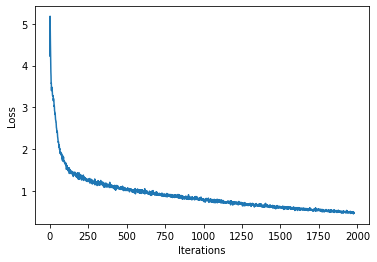

 99%|█████████▉| 1982/2000 [02:47<00:01, 11.19it/s]

200678
[193485 122316  83964 144541  80926  41780 160434  39510 174960 118899
 147619 156436 172464 146175 154527 193513  96403   8015 104904  43844
  27066 128809 177592 164212  43904  90964 196865   4910  25180 195553
  95699  86560 102282  52116  40328  45649  30920  27964 121872   2685
   3565 105019  25481  39460  34578 146088 174153 191983 183273  25834
 156944  72191  94014 188497  90173 177429 157945 127085  79631  67390
  53391  89373 113129 143932]
[array([82, 27, 14, 58,  1, 62, 14, 60,  1, 59, 27, 26, 82, 27, 14, 58,  1,
       60, 14, 61,  1, 62, 14, 56, 82, 57, 14, 56,  1, 62, 14, 60,  1, 59,
       27, 26, 22, 82,  2,  0, 27, 15,  1, 27, 14, 26,  1, 32, 14, 26, 82,
       27, 15,  1, 27, 26, 27,  1, 59, 27, 26, 82, 27, 15,  1, 27, 14, 26,
        1, 32, 14, 26, 82, 27, 14, 59,  1, 62, 14, 60,  1, 59, 27, 26, 22,
       82,  2,  0,  0, 49, 22, 17,  0, 45, 22, 28, 63, 70, 64, 58]), array([ 9, 73, 60, 60, 67,  9, 13, 17, 13,  0, 38, 22, 28,  0, 37, 22, 13,
       11, 20,  0

 99%|█████████▉| 1984/2000 [02:47<00:01, 11.79it/s]

200678
[161334 169091 161581  65171  11374 196437 113782  63014 126300 146272
 177870    182 121263 117257  29884 134563  66432   7478  95090 192029
  99815  62184  65246  30622 115005 195916 194449  77153 151632 194710
 123330 177004 141038 125708 182234  43179 190191 131697 109004  67994
  54379 189450 129241  72216  64987  68147  67541  26228   5337 166783
  57095 145466  94508  84986 188080  19635  26046 132146 131954  38927
  60286 187179  24716 128462]
[array([29, 14, 22, 82,  2,  0,  0, 49, 22, 15, 14, 14,  0, 45, 22, 44, 56,
       64, 69, 75,  1, 26, 69, 69, 60,  5, 74,  0, 51, 22,  1, 64, 59, 22,
       59, 58,  9, 73, 60, 60, 67,  9, 15, 12, 12,  0, 38, 22, 28,  0, 37,
       22, 13, 11, 20,  0, 36, 22, 29,  1, 38, 56, 65, 70, 73,  0, 59, 60,
       82, 61, 60, 59, 61,  1, 60, 59, 27, 59, 82, 26, 14, 31, 26,  1, 29,
       26, 31, 26, 82, 27, 14, 32, 27,  1, 30, 27, 32, 27, 82, 26]), array([14, 82, 53,  2,  0,  0, 49, 22, 15, 17, 18,  0, 45, 22, 45, 70, 68,
       68, 80,  1

 99%|█████████▉| 1988/2000 [02:47<00:00, 12.68it/s]

200678
[126656  35399  55162   9019 141022 113646  26162 124486   9515 176642
  44895 101454  60649  54415  14992  96532 107295  99114  95403  49464
  21620 191955  35136  19052 159838 180291 181841 160963  82407  47193
 138598  38998 176873 179155  34624 168062  77775 189470  48138 182674
 183675   8241 114519  53637 172731  45374  80683 115631  51999  91124
 123888 142560  39251 167623  16652 168893 182301  32748 190905 166669
  62931  15983 177033  33594]
[array([32, 15, 26, 82,  2,  0, 32, 26, 27, 59,  1, 60, 59, 62, 60, 82, 59,
       27, 27, 14,  1, 59, 60, 62, 56, 82, 57, 62, 62, 57,  1, 56, 62, 60,
       62, 82, 59, 27, 26, 27,  1, 32, 15, 82, 53,  2,  0,  0, 49, 22, 13,
       20, 14,  0, 45, 22, 36, 64, 67, 67, 70, 73, 56, 69,  5, 74,  0, 51,
       22,  1, 64, 59, 22, 59, 58,  9, 73, 60, 60, 67,  9, 13, 18, 18,  0,
       38, 22, 28,  0, 37, 22, 13, 11, 20,  0, 36, 22, 29,  1, 38]), array([82, 26, 32, 31,  1, 32, 27, 59, 82,  2,  0, 62, 15,  1, 57, 56, 62,
       82, 61, 60

100%|█████████▉| 1990/2000 [02:47<00:00, 12.85it/s]

200678
[116393  78366 136973   1997  21215 145255 104977 154947  35128   8216
  76528  36535 135625   7237 125709  38276  87690 100663 140253 125914
  76626  15438 100554 181441 105445  52920 180557 151072 144112 110577
 139168 164413 150938  66221  87962  61168 120744 175442  30014  77889
  25928   7867 159237 182092 192953  29559 145437 171305   5512 128085
 105859  30522  99494  78019  95085 110006  88858  19703 160591  57383
  83430 153551  20162  35170]
[array([82, 60, 62, 61, 59,  1, 60, 59, 82, 53,  2,  0,  0, 49, 22, 13, 16,
       13,  0, 45, 22, 33, 60, 56, 75, 63, 60, 73,  1, 27, 73, 60, 60, 81,
       60,  0, 51, 22,  1, 64, 59, 22, 59, 58,  9, 73, 60, 60, 67,  9, 15,
       18, 17,  0, 38, 22, 28,  0, 37, 22, 13, 11, 20,  0, 36, 22, 32,  1,
       38, 56, 65, 70, 73,  0, 32, 30, 82, 29, 32, 27, 32,  1, 59, 32, 27,
       32, 82, 29, 31, 26, 31,  1, 58, 31, 26, 31, 82, 29, 32, 27]), array([60,  1, 60, 62, 11, 60, 11, 82, 59, 27,  1, 26, 27, 11, 26, 11, 82,
       32, 14,  1

100%|█████████▉| 1994/2000 [02:48<00:00, 13.22it/s]

200678
[112836  94111  69274 149765 125018  39326  79167 190329 107612 105766
 112308 112907  48317 126942  71715  71175 131253   2120  32845 118969
 132932 154584  82439 137955  70505  33130  67730 121425 153994 133597
 145270 186613  38985  74265  96164  27140 149023  51274  92802 134759
  34416 113367 156720  81100  62308   1847 191200 150412 144940  86202
 112625  47225 119437 122258 147073  94883 167479  26569 187350  60133
 104560  13829 149299  15369]
[array([60, 59,  1, 58, 26, 32, 58, 82, 26, 27, 58, 26,  1, 59, 58, 26, 32,
       82, 26, 27, 58, 26,  1, 59, 15, 22, 82,  2,  0, 27, 82, 26, 59, 59,
       14,  1, 61, 59, 59, 14, 82, 60, 61, 62, 60,  1, 56, 62, 60, 59, 82,
       54, 58, 59, 60, 61,  1, 62, 14, 60, 61, 82, 62, 15, 60,  1, 59, 58,
       26, 54, 58, 82,  2,  0, 59, 14, 26, 27,  1, 32, 27, 26, 32, 82, 31,
       32, 26, 27,  1, 58, 14, 26, 32, 82, 26, 27, 58, 26,  1, 59]), array([64, 56, 69,  0, 31, 15, 32,  1, 26, 14, 27, 32, 82, 26, 14, 27, 32,
        1, 26, 32

100%|█████████▉| 1996/2000 [02:48<00:00, 13.19it/s]

200678
[136334 124540  38460 140736  70278 161576  61897 158248 170319 155011
 146192  23165 109782 188194  50521 142797 124022 192910   3058 121065
  84074 124424 111798 167779  41265 186284 178611   1686 144068    930
  87211  66482  71052  50726 136277  50779  55897  78442  49413 172835
  24837  15470 171481  17017  32132 182983  77105 154178  85720 186528
 100064 150564 151863 169536  17797 113834  96338    158  92270 195445
  59497 190792  91937 134548]
[array([ 1, 61, 26, 60, 26, 82, 30, 31, 26, 58,  1, 59, 58, 27, 26, 82, 27,
       58, 59, 60,  1, 61, 60, 61, 56, 82, 26, 14, 58, 27,  1, 26, 14, 22,
       82,  2,  0,  0, 49, 22, 14, 13, 21,  0, 45, 22, 38, 56, 74, 75, 60,
       73,  1, 28, 73, 70, 78, 67, 60, 80,  5, 74,  1, 39, 70, 10,  1, 13,
        0, 51, 22,  1, 64, 59, 22, 59, 58,  9, 73, 60, 60, 67,  9, 14, 12,
       12,  0, 38, 22, 28,  0, 37, 22, 13, 11, 20,  0, 36, 22, 29]), array([14, 30, 29,  1, 28, 29, 30, 32, 82, 58, 59, 60, 59,  1, 58, 26, 32,
       30, 82, 31

100%|██████████| 2000/2000 [02:48<00:00, 11.87it/s]


200678
[163833  23727  22164  70914  24085 127124 194824  17123 192461  75516
 193745  80856 151657  61076  28476 170718 182245  90061 186804 175781
  41434 139876 179501  14340  66136 198230   9161 133366 176756 183397
   1106 186285 160969 101256  99845  14367  48191  70156   1862  66967
 136850 121572 179734 182455  11000 133871 185897  65508 185877 101694
  68051  70882 183571  49924 140725 111007 118667 139665  54614 105548
 179658 174256 135735 162014]
[array([45, 22, 44, 63, 64, 71, 74,  1, 26, 73, 60,  1, 44, 56, 64, 67, 64,
       69, 62,  0, 51, 22,  1, 64, 59, 22, 59, 58,  9, 73, 60, 60, 67,  9,
       15, 13, 12,  0, 38, 22, 28,  0, 37, 22, 13, 11, 20,  0, 36, 22, 30,
        1, 29, 70, 73, 64, 56, 69,  0, 60, 59, 82, 27, 60, 60, 59,  1, 27,
       58, 59, 27, 82, 26, 29, 31, 29,  1, 26, 29, 31, 29, 82, 30, 29, 30,
       31,  1, 32, 31, 32, 26, 82, 27, 60, 60, 61,  1, 62, 61, 60]), array([27, 58, 82,  2,  0, 59, 61, 59,  1, 58, 60, 58, 82, 27, 59, 27,  1,
       26, 31, 26

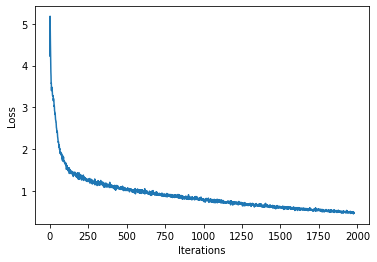

In [ ]:
# Optimization parameters:
num_training_iterations = 2000  # Increase this to train longer
batch_size = 64  # Experiment between 1 and 64
seq_length = 100  # Experiment between 50 and 500
learning_rate = 5e-3  # Experiment between 1e-5 and 1e-1

# Model parameters: 
vocab_size = len(vocab)
embedding_dim = 256 
rnn_units = 1024  # Experiment between 1 and 2048

model = build_model(vocab_size, embedding_dim, rnn_units, batch_size)
optimizer = tf.keras.optimizers.Adam(learning_rate)

@tf.function
def train_step(x, y): 
  # Use tf.GradientTape()
  with tf.GradientTape() as tape:

    '''TODO: feed the current input into the model and generate predictions'''
    y_hat = model(x)

    '''TODO: compute the loss!'''
    loss = compute_loss(y, y_hat)

  # Now, compute the gradients 
  '''TODO: complete the function call for gradient computation. 
      Remember that we want the gradient of the loss with respect all 
      of the model parameters. 
      HINT: use model.trainable_variables to get a list of all model
      parameters.'''
  grads = tape.gradient(loss, model.trainable_variables)

  # Apply the gradients to the optimizer so it can update the model accordingly
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss
history = []
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for iter in tqdm(range(num_training_iterations)):

  # Grab a batch and propagate it through the network
  x_batch, y_batch = get_batch(vectorized_songs, seq_length, batch_size)
  loss = train_step(x_batch, y_batch)

  # Update the progress bar
  history.append(loss.numpy().mean())
  plotter.plot(history)

  # Update the model with the changed weights!
  if iter % 100 == 0:
    model.save_weights(checkpoint_prefix)

# Save the trained model and the weights
model.save_weights(checkpoint_prefix)

In [ ]:

generated_text = generate_text(model, start_string="X", generation_length=1000) # TODO

### Play back generated songs ###

generated_songs = mdl.lab1.extract_song_snippet(generated_text)

for i, song in enumerate(generated_songs): 
  # Synthesize the waveform from a song
  waveform = mdl.lab1.play_song(song)

  # If its a valid song (correct syntax), lets play it! 
  if waveform:
    print("Generated song", i)
    ipythondisplay.display(waveform)

## Ans: When increasing the batch size, there is no fluctiations in loss and the model converges

### Question 2
- Experiment between 50 and 500 in sequence length and comment on the relationship between sequence length, quality of the output song, and training.

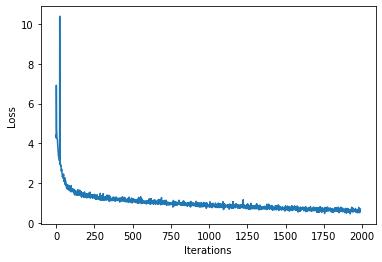

100%|█████████▉| 1992/2000 [03:53<00:01,  7.89it/s]

200678
[106905   5544 146376  47213]
[array([27, 58, 27, 26, 82, 32, 15, 31,  1, 32, 27, 59, 27, 82, 26, 31, 29,
       31,  1, 26, 58, 27, 26, 22, 82,  2,  0, 32, 14, 27, 32,  1, 59, 32,
       27, 32, 82, 32, 14, 27, 59,  1, 60, 61, 62, 14, 82, 32, 14, 27, 32,
        1, 59, 32, 27, 32, 82, 26, 31, 29, 31,  1, 26, 58, 27, 26, 82,  2,
        0, 32, 14, 27, 32,  1, 59, 32, 27, 32, 82, 32, 14, 27, 59,  1, 60,
       61, 62, 14, 82, 56, 61, 62, 60,  1, 59, 60, 59, 27, 82, 26, 31, 29,
       31,  1, 26, 58, 27, 26, 22, 82,  2,  0,  0, 49, 22, 13, 12, 15,  0,
       45, 22, 31, 64, 69, 57, 56, 73,  1, 29, 78, 80, 60, 73,  5, 74,  0,
       51, 22,  1, 64, 59, 22, 59, 58,  9, 73, 60, 60, 67,  9, 21, 17,  0,
       38, 22, 28,  0, 37, 22, 13, 11, 20,  0, 36, 22, 26,  1, 38, 64, 79,
       70, 67, 80, 59, 64, 56, 69,  0, 26, 32, 82, 30, 26,  8, 28, 26,  8,
        1, 30, 26,  8, 28, 26,  8, 82, 32,  8, 15, 26,  8,  1, 27,  8, 26,
        8, 27,  8, 29, 82, 30, 26,  8, 27,  8, 30,  1, 26, 27,

100%|█████████▉| 1993/2000 [03:53<00:00,  8.26it/s]

200678
[ 26156 184150 169184  69957]
[array([60, 58, 60, 82, 59, 58, 27,  1, 26, 31, 59, 82, 26, 31, 59,  1, 26,
       31, 59, 82, 26, 32, 31,  1, 30, 14, 62, 82,  2,  0, 61, 59, 61,  1,
       60, 58, 60, 82, 59, 58, 27,  1, 26, 31, 26, 82, 27, 32, 27,  1, 27,
       58, 59, 82, 26, 31, 29,  1, 29, 14, 22, 82,  2,  0, 30, 82, 31, 15,
        1, 32, 31, 32, 82, 31, 32, 31,  1, 31, 30, 29, 82, 31, 15,  1, 32,
       31, 32, 82, 26, 31, 29,  1, 30, 31, 32, 82,  2,  0, 31, 15,  1, 32,
       31, 32, 82, 31, 32, 31,  1, 31, 30, 29, 82, 27, 32, 27,  1, 27, 58,
       59, 82, 26, 31, 29,  1, 29, 14, 22, 82,  2,  0,  0, 49, 22, 15, 16,
        0, 45, 22, 29, 70, 69, 69, 80, 57, 73, 70, 70, 66,  1, 31, 56, 64,
       73,  0, 51, 22,  1, 64, 59, 22, 59, 58,  9, 65, 64, 62,  9, 14, 20,
        0, 38, 22, 18, 11, 20,  0, 37, 22, 13, 11, 20,  0, 36, 22, 32,  1,
       38, 56, 65, 70, 73,  0, 29, 82, 32, 31, 32,  1, 26, 32, 26, 82, 27,
       60, 60,  1, 59, 27, 26, 82, 27, 26, 27,  1, 32, 26, 27,

100%|█████████▉| 1995/2000 [03:54<00:00,  8.82it/s]

200678
[ 26182  71632  72065 122890]
[array([62, 82,  2,  0, 61, 59, 61,  1, 60, 58, 60, 82, 59, 58, 27,  1, 26,
       31, 26, 82, 27, 32, 27,  1, 27, 58, 59, 82, 26, 31, 29,  1, 29, 14,
       22, 82,  2,  0, 30, 82, 31, 15,  1, 32, 31, 32, 82, 31, 32, 31,  1,
       31, 30, 29, 82, 31, 15,  1, 32, 31, 32, 82, 26, 31, 29,  1, 30, 31,
       32, 82,  2,  0, 31, 15,  1, 32, 31, 32, 82, 31, 32, 31,  1, 31, 30,
       29, 82, 27, 32, 27,  1, 27, 58, 59, 82, 26, 31, 29,  1, 29, 14, 22,
       82,  2,  0,  0, 49, 22, 15, 16,  0, 45, 22, 29, 70, 69, 69, 80, 57,
       73, 70, 70, 66,  1, 31, 56, 64, 73,  0, 51, 22,  1, 64, 59, 22, 59,
       58,  9, 65, 64, 62,  9, 14, 20,  0, 38, 22, 18, 11, 20,  0, 37, 22,
       13, 11, 20,  0, 36, 22, 32,  1, 38, 56, 65, 70, 73,  0, 29, 82, 32,
       31, 32,  1, 26, 32, 26, 82, 27, 60, 60,  1, 59, 27, 26, 82, 27, 26,
       27,  1, 32, 26, 27, 82, 26, 32, 30,  1, 30, 14, 29, 82,  2,  0, 32,
       31, 32,  1, 26, 32, 26, 82, 27, 60, 60,  1, 59, 27, 26,

100%|█████████▉| 1997/2000 [03:54<00:00,  9.17it/s]

200678
[198401  53610  76232 112451]
[array([27, 82, 58, 14,  1, 27, 14,  1, 26, 14, 82, 32, 29,  1,  6, 15, 30,
       31, 32,  1, 27, 59, 82, 62, 15, 22, 82,  2,  0,  0, 49, 22, 16,  0,
       45, 22, 32, 60, 69, 75, 67, 60,  1, 38, 56, 64, 59, 60, 69,  0, 51,
       22,  1, 64, 59, 22, 59, 58,  9, 78, 56, 67, 75, 81,  9, 13, 12,  0,
       38, 22, 15, 11, 16,  0, 37, 22, 13, 11, 20,  0, 36, 22, 32,  1, 38,
       56, 65, 70, 73,  0, 29, 14, 82, 32, 15,  1, 26,  1, 32, 14, 82, 31,
       14,  1, 30, 14,  1, 29, 14, 82, 59, 16,  1, 59, 14, 82, 60, 15,  1,
       61,  1, 62, 14, 82, 59, 15,  1, 58,  1, 27, 14, 82, 26, 16,  1, 32,
       14, 82, 30, 18, 82, 31, 15,  1, 30,  1, 29, 14, 82,  2,  0, 32, 15,
        1, 26,  1, 32, 14, 82, 31, 14,  1, 30, 14,  1, 29, 14, 82, 59, 16,
        1, 59, 14, 82, 60, 15,  1, 61,  1, 62, 14, 82, 59, 15,  1, 58,  1,
       27, 14, 82, 26, 16,  9, 26,  1, 32, 82, 32, 18,  9, 82, 32, 16, 22,
       82,  2,  0, 27, 14, 82, 59, 14,  1, 60, 14,  1, 61, 14,

100%|█████████▉| 1999/2000 [03:54<00:00,  9.23it/s]

200678
[ 84914 129542 161226  41968]
[array([60, 61, 82, 62, 56, 62, 60,  1, 59, 27, 32, 30, 82, 29, 30, 32, 26,
        1, 27, 59, 62, 60, 82, 59, 27, 26, 58,  1, 27, 32, 32, 22, 82,  2,
        0,  0, 49, 22, 13, 14,  0, 45, 22, 27, 64, 73, 59,  5, 74,  1, 39,
       60, 74, 75,  0, 51, 22,  1, 64, 59, 22, 59, 58,  9, 73, 60, 60, 67,
        9, 15, 20, 16,  0, 38, 22, 28,  0, 37, 22, 13, 11, 20,  0, 36, 22,
       26,  1, 29, 70, 73, 64, 56, 69,  0, 58, 26, 26, 14,  1, 32, 26, 27,
       32, 82, 26, 14, 26, 27,  1, 58, 59, 60, 59, 82, 58, 26, 26, 14,  1,
       32, 26, 27, 32, 82, 26, 56, 62, 60,  1, 59, 58, 60, 59, 82,  2,  0,
       58, 26, 26, 14,  1, 32, 26, 27, 32, 82, 26, 14, 26, 27,  1, 58, 59,
       60, 59, 82, 58, 26, 26, 14,  1, 32, 26, 27, 32, 82, 26, 56, 62, 60,
        1, 59, 60, 58, 59, 82, 53,  2,  0, 36, 22, 28,  1, 38, 56, 65, 70,
       73,  0, 60, 58, 56, 62,  1, 60, 62, 59, 62, 82, 60, 58, 62, 58,  1,
       56, 58, 62, 58, 82, 60, 58, 56, 62,  1, 60, 59, 58, 59,

100%|██████████| 2000/2000 [03:54<00:00,  8.52it/s]


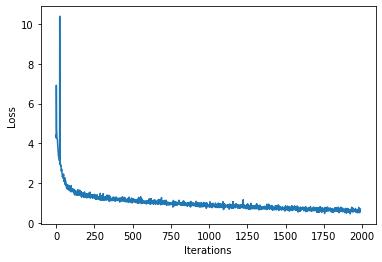

In [ ]:
# Optimization parameters:
num_training_iterations = 2000  # Increase this to train longer
batch_size = 4  # Experiment between 1 and 64
seq_length = 500  # Experiment between 50 and 500
learning_rate = 5e-3  # Experiment between 1e-5 and 1e-1

# Model parameters: 
vocab_size = len(vocab)
embedding_dim = 256 
rnn_units = 1024  # Experiment between 1 and 2048

model = build_model(vocab_size, embedding_dim, rnn_units, batch_size)
optimizer = tf.keras.optimizers.Adam(learning_rate)

@tf.function
def train_step(x, y): 
  # Use tf.GradientTape()
  with tf.GradientTape() as tape:

    '''TODO: feed the current input into the model and generate predictions'''
    y_hat = model(x)

    '''TODO: compute the loss!'''
    loss = compute_loss(y, y_hat)

  # Now, compute the gradients 
  '''TODO: complete the function call for gradient computation. 
      Remember that we want the gradient of the loss with respect all 
      of the model parameters. 
      HINT: use model.trainable_variables to get a list of all model
      parameters.'''
  grads = tape.gradient(loss, model.trainable_variables)

  # Apply the gradients to the optimizer so it can update the model accordingly
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss
history = []
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for iter in tqdm(range(num_training_iterations)):

  # Grab a batch and propagate it through the network
  x_batch, y_batch = get_batch(vectorized_songs, seq_length, batch_size)
  loss = train_step(x_batch, y_batch)

  # Update the progress bar
  history.append(loss.numpy().mean())
  plotter.plot(history)

  # Update the model with the changed weights!
  if iter % 100 == 0:
    model.save_weights(checkpoint_prefix)

# Save the trained model and the weights
model.save_weights(checkpoint_prefix)

In [ ]:
'''TODO: Rebuild the model using a batch_size=1'''
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

# Restore the model weights for the last checkpoint after training
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

generated_text = generate_text(model, start_string="X", generation_length=1000) # TODO

### Play back generated songs ###

generated_songs = mdl.lab1.extract_song_snippet(generated_text)

for i, song in enumerate(generated_songs): 
  # Synthesize the waveform from a song
  waveform = mdl.lab1.play_song(song)

  # If its a valid song (correct syntax), lets play it! 
  if waveform:
    print("Generated song", i)
    ipythondisplay.display(waveform)

100%|██████████| 1000/1000 [00:06<00:00, 158.61it/s]


Found 6 songs in text
Generated song 1


## Ans: Increasing the seq length increase the output quality, the model converges, But decreasing the seq length results in lower output quality

### Question 3
- Experiment between 1e-5 and 1e-1 in learning rate and comment on how it affects training and convergence


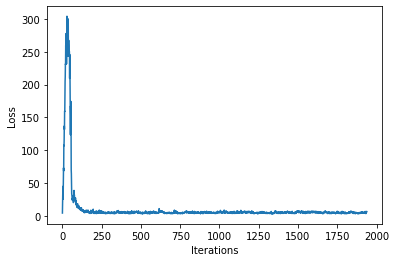

 97%|█████████▋| 1944/2000 [00:56<00:02, 20.74it/s]

200678
[155035  84998  61641  73315]
[array([61, 60, 82, 59, 61, 56, 61,  1, 57, 61, 56, 61, 82, 62, 14, 57, 62,
        1, 60, 61, 61, 22, 82,  2,  0, 60, 82, 61, 14, 61, 60,  1, 59, 58,
       59, 27, 82, 26, 27, 26, 31,  1, 29, 31, 26, 31, 82, 29, 31, 26, 31,
        1, 27, 31, 26, 31, 82, 32, 14, 27, 32,  1, 30, 31, 31, 22, 82,  2,
        0,  0, 49, 22, 14, 21, 17,  0, 45, 22, 41, 64, 71, 60, 73,  5, 74,
        1, 29, 60, 74, 71, 56, 64, 73,  0, 51, 22,  1, 64, 59, 22]), array([22, 26,  1, 29, 70, 73, 64, 56, 69,  0, 58, 26, 26, 14,  1, 32, 26,
       27, 32, 82, 26, 14, 26, 27,  1, 58, 59, 60, 59, 82, 58, 26, 26, 14,
        1, 32, 26, 27, 32, 82, 26, 56, 62, 60,  1, 59, 58, 60, 59, 82,  2,
        0, 58, 26, 26, 14,  1, 32, 26, 27, 32, 82, 26, 14, 26, 27,  1, 58,
       59, 60, 59, 82, 58, 26, 26, 14,  1, 32, 26, 27, 32, 82, 26, 56, 62,
       60,  1, 59, 60, 58, 59, 82, 53,  2,  0, 36, 22, 28,  1, 38]), array([32, 26,  1, 27, 14, 82, 26, 32,  1, 30, 28, 82, 29, 14,  1, 29, 14,

 98%|█████████▊| 1952/2000 [00:56<00:01, 26.51it/s]

200678
[ 78191 115950  67175  29515]
[array([ 2,  0, 27, 14,  1, 27, 25, 58, 82, 59, 27,  1, 26, 32, 82, 31, 25,
       30,  1, 31, 32, 82, 26, 27,  1, 58, 11, 27, 11, 26, 82,  2,  0, 27,
       14,  1, 27, 25, 58, 82, 59, 27,  1, 27, 62, 82, 61, 59,  1, 58, 26,
       82, 32, 14,  1, 32, 14, 22, 82,  2,  0,  0, 49, 22, 14, 21,  0, 45,
       22, 38, 56, 62, 62, 64, 60,  1, 64, 69,  1, 75, 63, 60,  1, 48, 70,
       70, 59,  0, 51, 22,  1, 64, 59, 22, 59, 58,  9, 71, 70, 67]), array([20,  0, 36, 22, 29,  1, 38, 56, 65, 70, 73,  0, 59, 29, 29, 14,  1,
       31, 26, 26, 14, 82, 59, 61, 56, 61,  1, 62, 61, 60, 58, 82, 59, 29,
       29, 14,  1, 31, 26, 26, 14, 82, 27, 32, 30, 31,  1, 32, 26, 27, 58,
       82,  2,  0, 59, 29, 29, 14,  1, 31, 26, 26, 14, 82, 59, 61, 56, 61,
        1, 62, 61, 60, 62, 82, 61, 56, 60, 58,  1, 59, 27, 26, 31, 82, 32,
       31, 30, 31,  1, 32, 26, 27, 58, 22, 82,  2,  0, 59, 14, 61]), array([56, 65, 70, 73,  0, 29, 14, 82, 32, 16,  1, 29, 14, 82, 32, 14,  1,

 98%|█████████▊| 1960/2000 [00:57<00:01, 28.46it/s]

200678
[141941 174463 192513 166848]
[array([59, 15, 61,  1, 56, 14, 61, 56, 82, 62, 57, 56, 61,  1, 60, 15, 22,
       82,  2,  0, 62, 82, 61, 14, 59, 61,  1, 60, 14, 58, 60, 82, 59, 58,
       59, 26,  1, 27, 58, 59, 60, 82, 61, 15, 59,  1, 60, 59, 58, 60, 82,
       59, 14, 26, 32,  1, 31, 29, 29, 22, 82,  2,  0,  0, 49, 22, 14, 16,
       14,  0, 45, 22, 38, 64, 74, 74,  1, 45, 63, 70, 73, 69, 75, 70, 69,
        5, 74,  0, 51, 22,  1, 64, 59, 22, 59, 58,  9, 73, 60, 60]), array([ 2,  0, 59, 14, 61, 59,  1, 62, 60, 61, 60, 82, 59, 61, 60, 59,  1,
       58, 59, 60, 62, 82, 61, 15, 59,  1, 62, 15, 60, 82, 58, 59, 60, 58,
        1, 59, 15, 82, 53,  2,  0, 61, 82, 60, 59, 58, 27,  1, 26, 14, 58,
       26, 82, 60, 26, 26, 14,  1, 60, 26, 61, 26, 82, 60, 59, 58, 27,  1,
       26, 15, 60, 82, 61, 62, 61, 60,  1, 59, 15, 61, 82,  2,  0, 60, 59,
       58, 27,  1, 26, 27, 58, 59, 82, 60, 26, 26, 14,  1, 60, 26]), array([79, 70, 67, 80, 59, 64, 56, 69,  0, 59, 58, 26,  1, 26, 32, 30, 82,

 98%|█████████▊| 1968/2000 [00:57<00:01, 31.19it/s]

200678
[183801 123739    704  47380]
[array([75, 59, 56, 69, 58, 60,  9, 14, 20,  0, 38, 22, 18, 11, 20,  0, 37,
       22, 13, 11, 20,  0, 36, 22, 29,  1, 38, 56, 65, 70, 73,  0, 59, 60,
       59,  1, 61, 60, 59, 82, 58, 27, 26,  1, 58, 60, 58, 82, 27, 58, 27,
        1, 61, 59, 27, 82, 27, 58, 27,  1, 61, 59, 27, 82,  2,  0, 59, 60,
       59,  1, 61, 60, 59, 82, 58, 27, 26,  1, 58, 60, 58, 82, 26, 27, 26,
        1, 60, 58, 26, 82, 26, 27, 26,  1, 60, 58, 26, 22, 82,  2]), array([59,  1, 60, 62, 61, 59, 82, 26, 14, 58, 26,  1, 60, 26, 58, 26, 82,
       59, 60, 61, 59,  1, 60, 14, 61, 62, 82, 56, 57, 56, 62,  1, 61, 59,
       60, 58, 82,  2,  0, 59, 60, 61, 59,  1, 60, 62, 61, 59, 82, 26, 14,
       58, 26,  1, 60, 26, 58, 26, 82, 59, 60, 61, 62,  1, 56, 57, 56, 62,
       82, 61, 59, 60, 58,  1, 59, 15, 82, 53,  2,  0,  0, 49, 22, 13, 19,
       13,  0, 45, 22, 35, 70, 67, 67, 80,  1, 45, 64, 69, 66, 60]), array([26,  1, 27, 58, 59, 60, 82, 61, 62, 61, 60,  1, 59, 58, 59, 27, 82,

 99%|█████████▊| 1972/2000 [00:57<00:00, 30.39it/s]

200678
[ 69558  14000 169124 169446]
[array([14,  1, 60, 14, 82, 61, 14,  1, 59, 14,  1, 61, 14, 82, 60, 16,  1,
       59, 14, 82, 59, 60,  1, 61, 62,  1, 56, 14, 82, 56, 14,  1, 57, 14,
        1, 62, 14, 82, 61, 14,  1, 59, 14,  1, 61, 14, 82, 60, 16,  1, 59,
       14, 82,  2,  0, 59, 60,  1, 61, 62,  1, 56, 14, 82, 56, 14,  1, 57,
       14,  1, 62, 14, 82, 61, 15,  1, 62,  1, 60, 14, 82, 59, 16,  1, 61,
       14, 82, 62, 61,  1, 60, 16, 82, 60, 14,  1, 61, 14,  1, 59]), array([14, 26, 14,  1, 26, 58, 27, 26, 82, 32, 30, 29, 30,  1, 32, 26, 27,
       59, 82,  6, 15, 60, 61, 62,  1, 61, 56,  1, 62, 60, 59, 27, 82, 58,
       14, 26, 14,  1, 26, 14, 22, 82,  2,  0,  0, 49, 22, 17, 15,  0, 45,
       22, 44, 63, 60, 73, 67, 70, 58, 66,  5, 74,  0, 51, 22,  1, 64, 59,
       22, 59, 58,  9, 63, 70, 73, 69, 71, 64, 71, 60,  9, 16, 20,  0, 38,
       22, 28, 82,  0, 37, 22, 13, 11, 20,  0, 36, 22, 32,  1, 38]), array([59, 58,  9, 73, 60, 60, 67,  9, 15, 18, 14,  0, 38, 22, 28,  0, 37,

 99%|█████████▉| 1980/2000 [00:57<00:00, 29.76it/s]

200678
[  3373   5394  68335 188347]
[array([22, 59, 58,  9, 63, 70, 73, 69, 71, 64, 71, 60,  9, 13, 15,  0, 38,
       22, 28, 82,  0, 37, 22, 13, 11, 20,  0, 36, 22, 32,  1, 38, 56, 65,
       70, 73,  0, 59, 58, 82, 27, 32, 27, 59,  1, 58, 26, 31, 26, 82, 59,
       54, 58, 59, 60,  1, 59, 27, 32, 31, 82, 30, 32, 58, 27,  1, 26, 32,
       31, 32, 82,  6, 15, 26, 27, 26,  1,  6, 15, 32, 31, 30,  1, 29, 14,
       27,  8, 29, 82,  2,  0, 27, 32, 27, 59,  1, 58, 26, 31, 26]), array([82, 59, 14, 60, 58,  1, 59, 58, 27, 26, 82, 62, 61, 62, 57,  1, 56,
       61, 59, 61, 82, 60, 26, 27, 58,  1, 59, 14, 22, 82,  2,  0, 27, 24,
       58, 82, 59, 62, 62, 14,  1, 57, 62, 62, 14, 82, 59, 62, 57, 62,  1,
       56, 62, 61, 60, 82, 26, 14, 58, 60,  1, 26, 14, 58, 60, 82, 61, 59,
       60, 58,  1, 59, 58, 27, 26, 82,  2,  0, 59, 62, 62, 14,  1, 57, 62,
       62, 14, 82, 59, 62, 57, 62,  1, 56, 62, 60, 61, 82, 62, 61]), array([29, 14,  1, 29, 30,  1, 31, 32, 82, 26, 27,  1, 58, 14,  1, 26, 14,

 99%|█████████▉| 1984/2000 [00:57<00:00, 30.74it/s]

200678
[167470 137187 131445  53188]
[array([14,  1, 59, 27, 58, 26, 82, 27, 59, 26, 31,  1, 32, 31, 32, 27, 82,
       26, 31, 31, 14,  1, 59, 27, 58, 26, 82, 27, 59, 26, 31,  1, 29, 15,
       82, 53,  2,  0, 60, 82, 61, 59, 60, 59,  1, 58, 26, 26, 60, 82, 61,
       59, 60, 61,  1, 62, 61, 62, 60, 82, 61, 59, 60, 59,  1, 58, 26, 26,
       24, 58, 82, 27, 59, 26, 32,  1, 31, 29, 29, 22, 82,  2,  0,  0, 49,
       22, 15, 16, 21,  0, 45, 22, 44, 78, 56, 67, 67, 70, 78,  5]), array([59, 14, 61, 60,  1, 59, 27, 27, 14, 82, 26, 31, 31, 14,  1, 29, 30,
       31, 26, 82, 27, 14, 26, 31,  1, 30, 32, 31, 30, 82,  2,  0, 29, 14,
       31, 26,  1, 29, 14, 31, 26, 82, 59, 14, 61, 60,  1, 59, 27, 27, 14,
       82, 26, 31, 31, 14,  1, 29, 30, 31, 26, 82, 27, 31, 26, 31,  1, 29,
       14, 22, 82,  2,  0, 31, 26, 82, 59, 61, 61, 14,  1, 59, 61, 61, 14,
       82, 62, 14, 57, 62,  1, 56, 61, 60, 61, 82, 59, 27, 27, 14]), array([ 1, 26, 14, 27, 58, 82, 58, 27, 27, 26,  1, 27, 31, 26, 31, 82, 30,

100%|█████████▉| 1992/2000 [00:58<00:00, 31.91it/s]

200678
[  7160 156295  97815 135341]
[array([58, 82, 27, 26, 27, 58,  1, 27, 14, 58, 59, 82, 60, 59, 60, 61,  1,
       60, 59, 58, 27, 82,  6, 15, 26, 27, 26,  1, 54, 32, 27,  1, 26, 14,
        1,  6, 15, 26, 27, 58, 82,  2,  0, 59, 58, 59, 60,  1, 61, 59, 26,
       31, 82, 32, 31, 32, 26,  1, 27, 59, 58, 27, 82, 26, 59, 58, 27,  1,
       26, 32, 31, 30, 82, 29, 14, 28, 30,  1, 29, 14, 22, 82,  2,  0,  0,
       49, 22, 14, 20,  0, 45, 22, 32, 56, 67, 78, 56, 80,  1, 27]), array([82, 58, 27, 26, 27,  1, 58, 59, 60, 61, 82, 62, 15, 60,  1, 59, 27,
       32, 26, 82, 27, 14, 59, 27,  1, 26, 16, 22, 82,  2,  0, 60, 56, 56,
       62,  1, 56, 15, 56, 82, 57, 56, 56, 14,  1, 57, 62, 56, 62, 82, 60,
       62, 62, 61,  1, 62, 15, 56, 82, 57, 62, 56, 62,  1, 57, 62, 56, 62,
       82,  2,  0, 60, 56, 56, 62,  1, 56, 62, 60, 59, 82, 27, 59, 60, 61,
        1, 62, 15, 60, 82, 60, 56, 56, 62,  1, 60, 62, 60, 59, 82]), array([32, 30, 29, 27,  8,  1, 32,  8, 26,  8, 26,  8, 22, 82,  2,  0, 29,

100%|██████████| 2000/2000 [00:58<00:00, 34.32it/s]

200678
[138262  45239 150241 121970]
[array([59,  1, 26, 15, 27, 82, 58, 26, 32, 30,  1, 30, 29, 29, 22, 82,  2,
        0, 27, 82, 26, 59, 61, 59,  1, 56, 59, 61, 59, 82, 26, 58, 60, 58,
        1, 62, 58, 60, 58, 82, 26, 59, 61, 59,  1, 56, 59, 61, 59, 82, 60,
       61, 62, 60,  1, 61, 59, 59, 27, 82,  2,  0, 26, 59, 61, 59,  1, 56,
       59, 61, 59, 82, 58, 59, 60, 61,  1, 62, 14, 61, 60, 82, 59, 60, 61,
       62,  1, 56, 15, 61, 82, 62, 61, 60, 62,  1, 61, 59, 59, 82]), array([80,  0, 51, 22,  1, 64, 59, 22, 59, 58,  9, 65, 64, 62,  9, 21, 14,
        0, 38, 22, 18, 11, 20,  0, 37, 22, 13, 11, 20,  0, 36, 22, 32,  1,
       38, 56, 65, 70, 73,  0, 32, 82, 58, 26, 31,  1, 32, 15, 82, 26, 58,
       26,  1, 32, 31, 32, 82, 58, 26, 31,  1, 32, 15, 82, 26, 31, 29,  1,
       31, 26, 59, 82,  2,  0, 58, 26, 31,  1, 32, 15, 82, 26, 58, 26,  1,
       32, 31, 32, 82, 61, 59, 59,  1, 60, 59, 59, 82, 61, 59, 59]), array([62, 56, 82, 57, 14, 62, 57,  1, 56, 14, 61, 56, 82, 62, 61, 62, 60,

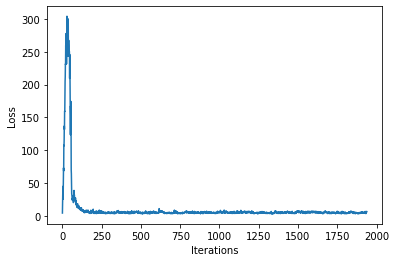

In [ ]:
# Optimization parameters:
num_training_iterations = 2000  # Increase this to train longer
batch_size = 4  # Experiment between 1 and 64
seq_length = 100  # Experiment between 50 and 500
learning_rate = 1e-1  # Experiment between 1e-5 and 1e-1

# Model parameters: 
vocab_size = len(vocab)
embedding_dim = 256 
rnn_units = 1024  # Experiment between 1 and 2048

model = build_model(vocab_size, embedding_dim, rnn_units, batch_size)
optimizer = tf.keras.optimizers.Adam(learning_rate)

@tf.function
def train_step(x, y): 
  # Use tf.GradientTape()
  with tf.GradientTape() as tape:

    '''TODO: feed the current input into the model and generate predictions'''
    y_hat = model(x)

    '''TODO: compute the loss!'''
    loss = compute_loss(y, y_hat)

  # Now, compute the gradients 
  '''TODO: complete the function call for gradient computation. 
      Remember that we want the gradient of the loss with respect all 
      of the model parameters. 
      HINT: use model.trainable_variables to get a list of all model
      parameters.'''
  grads = tape.gradient(loss, model.trainable_variables)

  # Apply the gradients to the optimizer so it can update the model accordingly
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss
history = []
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for iter in tqdm(range(num_training_iterations)):

  # Grab a batch and propagate it through the network
  x_batch, y_batch = get_batch(vectorized_songs, seq_length, batch_size)
  loss = train_step(x_batch, y_batch)

  # Update the progress bar
  history.append(loss.numpy().mean())
  plotter.plot(history)

  # Update the model with the changed weights!
  if iter % 100 == 0:
    model.save_weights(checkpoint_prefix)

# Save the trained model and the weights
model.save_weights(checkpoint_prefix)

In [ ]:
'''TODO: Rebuild the model using a batch_size=1'''
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

# Restore the model weights for the last checkpoint after training
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

generated_text = generate_text(model, start_string="X", generation_length=1000) # TODO

### Play back generated songs ###

generated_songs = mdl.lab1.extract_song_snippet(generated_text)

for i, song in enumerate(generated_songs): 
  # Synthesize the waveform from a song
  waveform = mdl.lab1.play_song(song)

  # If its a valid song (correct syntax), lets play it! 
  if waveform:
    print("Generated song", i)
    ipythondisplay.display(waveform)

100%|██████████| 1000/1000 [00:06<00:00, 160.40it/s]

Found 0 songs in text


## Ans: the model converges faster when increasing lr to 1e-1

### Question 4
- Experiment between 1 and 2048 in the number of rnn units and comment on how it affects training and the generated output song

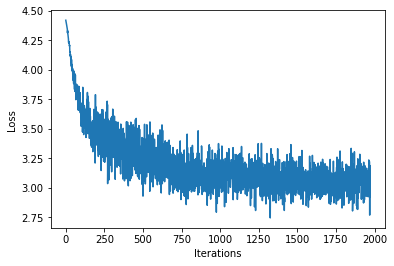

 99%|█████████▉| 1986/2000 [00:19<00:00, 86.08it/s]

200678
[164609 146604 161274 127520]
[array([32, 82, 31, 26, 26, 14,  1, 31, 26, 59, 61, 82,  2,  0, 56, 62, 61,
       62,  1, 60, 61, 59, 27, 82, 26, 31, 31, 14,  1, 29, 31, 26, 59, 82,
       27, 32, 32, 14,  1, 30, 14, 56, 62, 82, 61, 56, 60, 62,  1, 61, 59,
       59, 22, 82,  2,  0, 61, 82, 56, 14, 61, 59,  1, 26, 59, 61, 59, 82,
       60, 61, 60, 59,  1, 58, 26, 26, 14, 82, 56, 14, 61, 56,  1, 57, 62,
       60, 59, 82, 58, 60, 60, 59,  1, 60, 61, 62, 60, 82,  2,  0]), array([60, 56, 59, 70, 78,  0, 51, 22,  1, 64, 59, 22, 59, 58,  9, 73, 60,
       60, 67,  9, 14, 16, 14,  0, 38, 22, 28,  0, 37, 22, 13, 11, 20,  0,
       36, 22, 32,  1, 38, 56, 65, 70, 73,  0, 27, 82, 26, 29, 29, 14,  1,
       29, 15, 32, 82, 26, 58, 27, 32,  1, 26, 32, 30, 32, 82, 26, 29, 29,
       14,  1, 30, 29, 30, 31, 82, 32, 14, 26, 32,  1, 30, 32, 32, 27, 82,
        2,  0, 26, 29, 29, 14,  1, 29, 15, 32, 82, 26, 58, 27, 32]), array([82, 61, 57, 57, 14,  1, 57, 56, 61, 56, 82, 57, 14, 56, 61,  1, 61,

100%|██████████| 2000/2000 [00:19<00:00, 101.34it/s]


200678
[200505 119599 111848 117637]
[array([82,  2,  0, 59, 62, 15,  1, 27, 58, 82, 59, 15,  1, 58,  1, 26, 31,
       82, 32, 14,  1, 27, 15,  1, 26, 82, 32, 15, 22, 82,  2,  0, 62,  1,
       61, 62, 82, 56, 14,  1, 61, 14,  1, 59, 14, 82, 26, 14,  1, 31, 14,
        1, 29, 14, 82, 28, 14,  1, 57, 15,  1, 56, 82, 62, 56,  1, 61, 62,
        1, 60, 61, 82,  2,  0, 59, 15,  1, 60,  1, 59, 14, 82, 27, 15,  1,
       26,  1, 27, 14, 82, 29, 14,  1, 31, 14,  1, 26, 14, 82, 58]), array([15, 18, 12,  0, 38, 22, 28,  0, 37, 22, 13, 11, 20,  0, 36, 22, 32,
        1, 38, 56, 65, 70, 73,  0, 29, 31, 82, 32, 14, 59, 32,  1, 27, 32,
       59, 32, 82, 26, 32, 31, 32,  1, 26, 27, 58, 26, 82, 27, 26, 32, 31,
        1, 32, 26, 27, 58, 82, 59, 60, 61, 59,  1, 58, 26, 31, 26, 82,  2,
        0, 27, 32, 32, 14,  1, 27, 32, 26, 32, 82, 31, 32, 26, 27,  1, 58,
       27, 58, 26, 82, 27, 32, 27, 59,  1, 58, 27, 26, 32, 82, 31]), array([32,  1, 26, 32, 30, 32, 82, 26, 14, 30, 26,  1, 31, 26, 30, 26, 82,

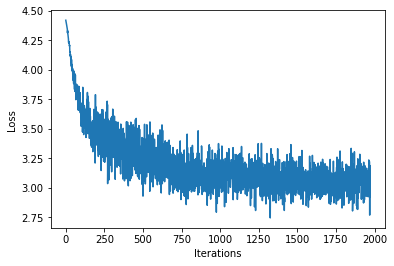

In [ ]:
# Optimization parameters:
num_training_iterations = 2000  # Increase this to train longer
batch_size = 4  # Experiment between 1 and 64
seq_length = 100  # Experiment between 50 and 500
learning_rate = 5e-3  # Experiment between 1e-5 and 1e-1

# Model parameters: 
vocab_size = len(vocab)
embedding_dim = 256 
rnn_units = 1  # Experiment between 1 and 2048

model = build_model(vocab_size, embedding_dim, rnn_units, batch_size)
optimizer = tf.keras.optimizers.Adam(learning_rate)

@tf.function
def train_step(x, y): 
  # Use tf.GradientTape()
  with tf.GradientTape() as tape:

    '''TODO: feed the current input into the model and generate predictions'''
    y_hat = model(x)

    '''TODO: compute the loss!'''
    loss = compute_loss(y, y_hat)

  # Now, compute the gradients 
  '''TODO: complete the function call for gradient computation. 
      Remember that we want the gradient of the loss with respect all 
      of the model parameters. 
      HINT: use model.trainable_variables to get a list of all model
      parameters.'''
  grads = tape.gradient(loss, model.trainable_variables)

  # Apply the gradients to the optimizer so it can update the model accordingly
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss
history = []
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for iter in tqdm(range(num_training_iterations)):

  # Grab a batch and propagate it through the network
  x_batch, y_batch = get_batch(vectorized_songs, seq_length, batch_size)
  loss = train_step(x_batch, y_batch)

  # Update the progress bar
  history.append(loss.numpy().mean())
  plotter.plot(history)

  # Update the model with the changed weights!
  if iter % 100 == 0:
    model.save_weights(checkpoint_prefix)

# Save the trained model and the weights
model.save_weights(checkpoint_prefix)

In [ ]:
'''TODO: Rebuild the model using a batch_size=1'''
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

# Restore the model weights for the last checkpoint after training
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

generated_text = generate_text(model, start_string="X", generation_length=1000) # TODO

### Play back generated songs ###

generated_songs = mdl.lab1.extract_song_snippet(generated_text)

for i, song in enumerate(generated_songs): 
  # Synthesize the waveform from a song
  waveform = mdl.lab1.play_song(song)

  # If its a valid song (correct syntax), lets play it! 
  if waveform:
    print("Generated song", i)
    ipythondisplay.display(waveform)

100%|██████████| 1000/1000 [00:05<00:00, 168.77it/s]


Found 2 songs in text


## Ans: When decreasing the rnn units the model doesnt learn anything and the generated output is garbage, but increasing the rnn units results in better training and the model convegres

### Question 5
- How do songs generated after training with a small number of epochs compare to those generated after a longer duration of training?

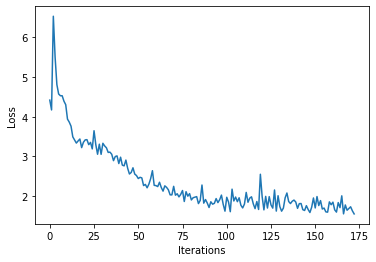

 90%|█████████ | 181/200 [00:06<00:00, 30.96it/s]

200678
[ 57966 173287 170578  74082]
[array([ 0, 36, 22, 30,  1, 29, 70, 73, 64, 56, 69,  0, 29, 82, 30, 27, 27,
        1, 27, 26, 32, 82, 31, 26, 26,  1, 26, 31, 29, 82, 30, 27, 27,  1,
       30, 27, 27, 82, 26, 32, 31,  1, 30, 14, 29, 82,  2,  0, 30, 27, 27,
        1, 27, 26, 32, 82, 31, 29, 31,  1, 26, 32, 31, 82, 32, 26, 27,  1,
       26, 59, 27, 82, 26, 32, 31,  1, 30, 14, 22, 82,  2,  0, 26, 82, 27,
       60, 60,  1, 60, 61, 62, 82, 61, 59, 61,  1, 60, 59, 26, 82]), array([ 1, 27, 30, 30, 14, 22, 82,  2,  0,  0, 49, 22, 15, 19, 16,  0, 45,
       22, 48, 60, 67, 67, 64, 69, 62, 75, 70, 69,  5, 74,  0, 51, 22,  1,
       64, 59, 22, 59, 58,  9, 73, 60, 60, 67,  9, 15, 16, 18,  0, 38, 22,
       28,  0, 37, 22, 13, 11, 20,  0, 36, 22, 32,  1, 38, 56, 65, 70, 73,
        0, 29, 82, 32, 14, 27, 32,  1, 29, 32, 27, 32, 82, 26, 15, 27,  1,
       58, 59, 60, 58, 82, 26, 15, 27,  1, 58, 26, 27, 32, 82, 31]), array([62, 59, 62, 82, 62, 14, 57, 62,  1, 56, 62, 60, 61, 82, 62, 61, 62,

 94%|█████████▍| 189/200 [00:06<00:00, 34.76it/s]

200678
[ 56334  52268 149419  14458]
[array([ 1, 59, 15, 22, 82,  2,  0, 61, 56, 56,  1, 56, 62, 61, 82, 60, 61,
       62,  1, 60, 61, 62, 82, 61, 15,  1, 62, 15, 82, 60, 58, 26,  1, 32,
       31, 30, 82,  2,  0, 29, 31, 26,  1, 59, 58, 59, 82, 60, 58, 26,  1,
       58, 59, 60, 82, 61, 15,  1, 62, 15, 82, 60, 59, 58,  1, 59, 15, 22,
       82,  2,  0,  0, 49, 22, 13, 17, 17,  0, 45, 22, 45, 70, 68,  1, 27,
       64, 67, 67, 80,  5, 74,  1, 39, 70, 10,  1, 13,  0, 51, 22]), array([32, 26,  1, 26, 31, 59, 82, 26, 31, 59,  1, 26, 27, 58, 82, 27, 59,
       27,  1, 58, 26, 31, 82, 32, 15,  1, 27, 26, 32, 22, 82,  2,  0, 31,
       32, 26,  1, 26, 31, 29, 82, 29, 30, 29,  1, 26, 31, 29, 82, 31, 32,
       26,  1, 26, 31, 29, 82, 32, 31, 32,  1, 27, 26, 32, 82,  2,  0, 31,
       32, 26,  1, 26, 31, 29, 82, 29, 30, 29,  1, 26, 27, 58, 82, 27, 59,
       27,  1, 58, 26, 31, 82, 32, 15,  1, 27, 26, 32, 22, 82,  2]), array([61, 59, 60, 58,  1, 59, 14, 82, 53,  2,  0,  0, 49, 22, 14, 19, 15,

 99%|█████████▉| 198/200 [00:07<00:00, 37.27it/s]

200678
[190379 153452  83227  31748]
[array([22, 18, 11, 20,  0, 37, 22, 13, 11, 20,  0, 36, 22, 30,  1, 29, 70,
       73, 64, 56, 69,  0, 30, 14, 27,  1, 27, 14, 26, 82, 27, 14, 58,  1,
       59, 15, 82, 31, 14, 26,  1, 26, 27, 26, 82, 29, 14, 30,  1, 31, 30,
       29, 82,  2,  0, 30, 14, 27,  1, 27, 14, 26, 82, 27, 14, 58,  1, 59,
       15, 82, 58, 59, 58,  1, 27, 14, 26, 82, 27, 14, 30,  1, 30, 15, 22,
       82,  2,  0, 60, 14, 61,  1, 62, 61, 60, 82, 59, 14, 27,  1]), array([41, 60, 60, 67, 60, 73,  5, 74,  1, 35, 56, 58, 66, 60, 75,  0, 51,
       22,  1, 64, 59, 22, 59, 58,  9, 73, 60, 60, 67,  9, 14, 18, 20,  0,
       38, 22, 28,  0, 37, 22, 13, 11, 20,  0, 36, 22, 32,  1, 38, 56, 65,
       70, 73,  0, 26, 31, 82, 32, 14, 27, 32,  1, 29, 32, 27, 32, 82, 31,
       32, 26, 27,  1, 58, 14, 27, 58, 82, 59, 62, 62, 61,  1, 59, 14, 60,
       62, 82, 61, 59, 58, 26,  1, 27, 32, 22, 82,  2,  0, 27, 59]), array([ 0,  0, 49, 22, 16,  0, 45, 22, 26, 73, 70, 76, 69, 59,  1, 75, 63,

100%|██████████| 200/200 [00:07<00:00, 28.02it/s]


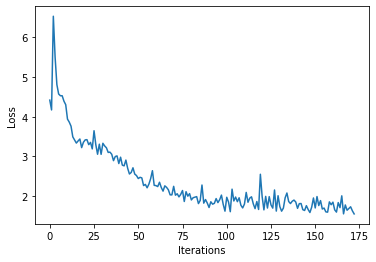

In [ ]:
# Optimization parameters:
num_training_iterations = 200  # Increase this to train longer
batch_size = 4  # Experiment between 1 and 64
seq_length = 100  # Experiment between 50 and 500
learning_rate = 5e-3  # Experiment between 1e-5 and 1e-1

# Model parameters: 
vocab_size = len(vocab)
embedding_dim = 256 
rnn_units = 1024  # Experiment between 1 and 2048

model = build_model(vocab_size, embedding_dim, rnn_units, batch_size)
optimizer = tf.keras.optimizers.Adam(learning_rate)

@tf.function
def train_step(x, y): 
  # Use tf.GradientTape()
  with tf.GradientTape() as tape:

    '''TODO: feed the current input into the model and generate predictions'''
    y_hat = model(x)

    '''TODO: compute the loss!'''
    loss = compute_loss(y, y_hat)

  # Now, compute the gradients 
  '''TODO: complete the function call for gradient computation. 
      Remember that we want the gradient of the loss with respect all 
      of the model parameters. 
      HINT: use model.trainable_variables to get a list of all model
      parameters.'''
  grads = tape.gradient(loss, model.trainable_variables)

  # Apply the gradients to the optimizer so it can update the model accordingly
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss
history = []
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for iter in tqdm(range(num_training_iterations)):

  # Grab a batch and propagate it through the network
  x_batch, y_batch = get_batch(vectorized_songs, seq_length, batch_size)
  loss = train_step(x_batch, y_batch)

  # Update the progress bar
  history.append(loss.numpy().mean())
  plotter.plot(history)

  # Update the model with the changed weights!
  if iter % 100 == 0:
    model.save_weights(checkpoint_prefix)

# Save the trained model and the weights
model.save_weights(checkpoint_prefix)

In [ ]:
'''TODO: Rebuild the model using a batch_size=1'''
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

# Restore the model weights for the last checkpoint after training
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

generated_text = generate_text(model, start_string="X", generation_length=1000) # TODO

### Play back generated songs ###

generated_songs = mdl.lab1.extract_song_snippet(generated_text)

for i, song in enumerate(generated_songs): 
  # Synthesize the waveform from a song
  waveform = mdl.lab1.play_song(song)

  # If its a valid song (correct syntax), lets play it! 
  if waveform:
    print("Generated song", i)
    ipythondisplay.display(waveform)

100%|██████████| 1000/1000 [00:06<00:00, 156.42it/s]


Found 3 songs in text


## Ans: The model needs more iterations to produce better output so the output of 2000 iterations is way better than the 200 iterations

### Question 6
- Train the model using the parameters you thought best from the above experiments and output the results and model below

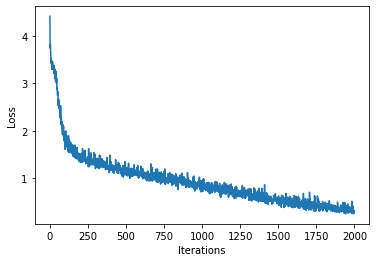

100%|██████████| 2000/2000 [03:52<00:00,  8.59it/s]


200678
[173149 126217 149896  73497]
[array([31, 82, 29, 31, 31, 14,  1, 26, 15, 27, 82, 26, 31, 27, 31,  1, 26,
       31, 30, 31, 82,  2,  0, 29, 27, 27, 26,  1, 27, 15, 26, 82, 27, 26,
       59, 27,  1, 26, 27, 59, 60, 82, 61, 15, 60,  1, 59, 60, 61, 60, 82,
       59, 27, 26, 31,  1, 27, 30, 30, 14, 22, 82,  2,  0, 59, 60, 61, 60,
        1, 59, 15, 26, 82, 27, 26, 31, 26,  1, 59, 27, 26, 27, 82, 59, 60,
       61, 60,  1, 59, 60, 61, 62, 82, 56, 14, 57, 61,  1, 56, 61, 60, 62,
       82,  2,  0, 61, 14, 59, 61,  1, 60, 61, 59, 27, 82, 26, 31, 31, 14,
        1, 26, 27, 59, 60, 82, 61, 15, 60,  1, 59, 60, 61, 60, 82, 59, 27,
       26, 31,  1, 27, 30, 30, 14, 22, 82,  2,  0,  0, 49, 22, 15, 19, 16,
        0, 45, 22, 48, 60, 67, 67, 64, 69, 62, 75, 70, 69,  5, 74,  0, 51,
       22,  1, 64, 59, 22, 59, 58,  9, 73, 60, 60, 67,  9, 15, 16, 18,  0,
       38, 22, 28,  0, 37, 22, 13, 11, 20,  0, 36, 22, 32,  1, 38, 56, 65,
       70, 73,  0, 29, 82, 32, 14, 27, 32,  1, 29, 32, 27, 32,

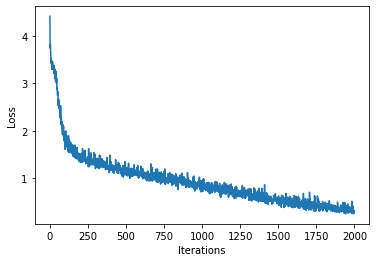

In [ ]:
# Optimization parameters:
num_training_iterations = 2000  # Increase this to train longer
batch_size = 4  # Experiment between 1 and 64
seq_length = 500  # Experiment between 50 and 500
learning_rate = 1e-3  # Experiment between 1e-5 and 1e-1

# Model parameters: 
vocab_size = len(vocab)
embedding_dim = 256 
rnn_units = 1024  # Experiment between 1 and 2048

model = build_model(vocab_size, embedding_dim, rnn_units, batch_size)
optimizer = tf.keras.optimizers.Adam(learning_rate)

@tf.function
def train_step(x, y): 
  # Use tf.GradientTape()
  with tf.GradientTape() as tape:

    '''TODO: feed the current input into the model and generate predictions'''
    y_hat = model(x)

    '''TODO: compute the loss!'''
    loss = compute_loss(y, y_hat)

  # Now, compute the gradients 
  '''TODO: complete the function call for gradient computation. 
      Remember that we want the gradient of the loss with respect all 
      of the model parameters. 
      HINT: use model.trainable_variables to get a list of all model
      parameters.'''
  grads = tape.gradient(loss, model.trainable_variables)

  # Apply the gradients to the optimizer so it can update the model accordingly
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss
history = []
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for iter in tqdm(range(num_training_iterations)):

  # Grab a batch and propagate it through the network
  x_batch, y_batch = get_batch(vectorized_songs, seq_length, batch_size)
  loss = train_step(x_batch, y_batch)

  # Update the progress bar
  history.append(loss.numpy().mean())
  plotter.plot(history)

  # Update the model with the changed weights!
  if iter % 100 == 0:
    model.save_weights(checkpoint_prefix)

# Save the trained model and the weights
model.save_weights(checkpoint_prefix)

In [ ]:
'''TODO: Rebuild the model using a batch_size=1'''
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

# Restore the model weights for the last checkpoint after training
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

generated_text = generate_text(model, start_string="X", generation_length=1000) # TODO

### Play back generated songs ###

generated_songs = mdl.lab1.extract_song_snippet(generated_text)

for i, song in enumerate(generated_songs): 
  # Synthesize the waveform from a song
  waveform = mdl.lab1.play_song(song)

  # If its a valid song (correct syntax), lets play it! 
  if waveform:
    print("Generated song", i)
    ipythondisplay.display(waveform)

In [ ]:
# Copyright 2022 MIT 